In [ ]:
# Source - https://github.com/sre-customer-training/lab1-estadistica-descriptiva

__author__ = "Andres M. Correa"
__copyright__ = "BSD 3-Clause License"
__credits__ = []
__license__ = "BSD"
__version__ = "3"
__maintainer__ = "Andres M. Correa"
__email__ = "amcorrea0@gmail.com"
__status__ = "Labs for SRE"

### Generación de Datos (El Dataset)

Generar un archivo llamado prometheus_alerts_export.csv con 500 registros simulando datos reales (incluyendo el ruido y la variabilidad típica de producción).

```
-------------------------------------------------------------
# BLOQUE 1: GENERADOR DE DATOS SINTÉTICOS (Ejecutar una vez)
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Configuración
NUM_ROWS = 500
START_TIME = datetime.now() - timedelta(days=7)

# Listas de simulación
services = ['payment-gateway', 'auth-service', 'frontend-ui', 'database-primary', 'redis-cache']
alert_names = ['HighCPUUsage', 'PodRestart', 'HighLatency', 'DiskSpaceLow', 'ErrorRateSpike']
severities = ['critical', 'warning', 'info']
regions = ['us-east-1', 'eu-west-1', 'sa-east-1']

data = []

for _ in range(NUM_ROWS):
    # Generar timestamps aleatorios en los últimos 7 días
    random_seconds = random.randint(0, 7 * 24 * 60 * 60)
    timestamp = START_TIME + timedelta(seconds=random_seconds)
    
    # Selección aleatoria ponderada (para que no sea todo uniforme)
    service = random.choice(services)
    alert = random.choice(alert_names)
    region = random.choice(regions)
    
    # Lógica simple: Críticos suelen durar más o ser más ruidosos
    severity = np.random.choice(severities, p=[0.2, 0.5, 0.3])
    
    # Duración simulada (Log-Normal distribution para simular "long tail" de incidentes reales)
    # La mayoría se resuelven rápido (minutos), algunos tardan horas.
    duration_sec = int(np.random.lognormal(mean=5, sigma=1.5)) 
    
    data.append([timestamp, service, alert, severity, region, duration_sec])

# Crear DataFrame y guardar
df_raw = pd.DataFrame(data, columns=['timestamp', 'service', 'alert_name', 'severity', 'region', 'duration_seconds'])
df_raw = df_raw.sort_values(by='timestamp')
df_raw.to_csv('../datos/prometheus_alerts_export.csv', index=False)

print(f"✅ Archivo '../datos/prometheus_alerts_export.csv' generado con {len(df_raw)} filas.")
print("Datos listos para el análisis.")
```

In [1]:
# -------------------------------------------------------------
# BLOQUE 1: GENERADOR DE DATOS SINTÉTICOS (Ejecutar una vez)
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Configuración
NUM_ROWS = 500
START_TIME = datetime.now() - timedelta(days=7)

# Listas de simulación
services = ['payment-gateway', 'auth-service', 'frontend-ui', 'database-primary', 'redis-cache']
alert_names = ['HighCPUUsage', 'PodRestart', 'HighLatency', 'DiskSpaceLow', 'ErrorRateSpike']
severities = ['critical', 'warning', 'info']
regions = ['us-east-1', 'eu-west-1', 'sa-east-1']

data = []

for _ in range(NUM_ROWS):
    # Generar timestamps aleatorios en los últimos 7 días
    random_seconds = random.randint(0, 7 * 24 * 60 * 60)
    timestamp = START_TIME + timedelta(seconds=random_seconds)
    
    # Selección aleatoria ponderada (para que no sea todo uniforme)
    service = random.choice(services)
    alert = random.choice(alert_names)
    region = random.choice(regions)
    
    # Lógica simple: Críticos suelen durar más o ser más ruidosos
    severity = np.random.choice(severities, p=[0.2, 0.5, 0.3])
    
    # Duración simulada (Log-Normal distribution para simular "long tail" de incidentes reales)
    # La mayoría se resuelven rápido (minutos), algunos tardan horas.
    duration_sec = int(np.random.lognormal(mean=5, sigma=1.5)) 
    
    data.append([timestamp, service, alert, severity, region, duration_sec])

# Crear DataFrame y guardar
df_raw = pd.DataFrame(data, columns=['timestamp', 'service', 'alert_name', 'severity', 'region', 'duration_seconds'])
df_raw = df_raw.sort_values(by='timestamp')
df_raw.to_csv('../datos/prometheus_alerts_export.csv', index=False)

print(f"✅ Archivo '../datos/prometheus_alerts_export.csv' generado con {len(df_raw)} filas.")
print("Datos listos para el análisis.")

✅ Archivo '../datos/prometheus_alerts_export.csv' generado con 500 filas.
Datos listos para el análisis.


## El Notebook de Análisis (Paso a Paso)

**Paso 1: Carga y Limpieza de Datos**

**Objetivo:** Entender la estructura y asegurar que las fechas sean fechas y no texto.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración estética para gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Cargar datos
df = pd.read_csv('../datos/prometheus_alerts_export.csv')

# 2. Conversión de tipos (CRUCIAL en Time Series)
# Pandas suele leer fechas como strings ('object'), debemos convertirlas.
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 3. Vista rápida
print("--- Estructura del Dataset ---")
print(df.info())
print("\n--- Primeras 5 filas ---")
display(df.head())

--- Estructura del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         500 non-null    datetime64[ns]
 1   service           500 non-null    object        
 2   alert_name        500 non-null    object        
 3   severity          500 non-null    object        
 4   region            500 non-null    object        
 5   duration_seconds  500 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 23.6+ KB
None

--- Primeras 5 filas ---


,timestamp,service,alert_name,severity,region,duration_seconds
0,2025-11-25 12:05:20.666909,frontend-ui,HighCPUUsage,warning,sa-east-1,31
1,2025-11-25 12:11:28.666909,database-primary,HighCPUUsage,warning,eu-west-1,102
2,2025-11-25 12:37:01.666909,redis-cache,HighLatency,critical,us-east-1,10
3,2025-11-25 13:05:32.666909,database-primary,HighCPUUsage,info,us-east-1,24
4,2025-11-25 13:14:08.666909,redis-cache,DiskSpaceLow,critical,us-east-1,24


**Paso 2: Estadística Descriptiva (Duración de Incidentes)**

*Objetivo:* Como SREs, el promedio nos miente. Necesitamos ver percentiles (P50, P95, P99) para entender el MTTR (Mean Time To Resolve) real.

In [5]:
# Cálculo de estadísticas básicas sobre la columna de duración
#stats_desc = df['duration_seconds'].describe(percentiles=[.25, .50, .75, .95, .99])
stats_desc = df['duration_seconds'].describe(percentiles=[.92, .95, .98, .99, .995])

print("--- Estadísticas de Duración (Segundos) ---")
print(stats_desc)

# Interpretación automática simple
p95 = stats_desc['95%']
print(f"\n💡 INSIGHT SRE: El 95% de tus alertas se resuelven en menos de {p95:.2f} segundos ({p95/60:.2f} minutos).")
print("Este valor es más útil que el promedio para definir SLAs.")

--- Estadísticas de Duración (Segundos) ---
count      500.000000
mean       405.700000
std       1196.532193
min          4.000000
50%        158.500000
92%        989.560000
95%       1297.550000
98%       2699.060000
99%       3867.010000
99.5%     5880.655000
max      21796.000000
Name: duration_seconds, dtype: float64

💡 INSIGHT SRE: El 95% de tus alertas se resuelven en menos de 1297.55 segundos (21.63 minutos).
Este valor es más útil que el promedio para definir SLAs.


**Paso 3: Análisis de Frecuencia (Top Offenders)**

*Objetivo:* Identificar qué servicios o alertas generan más ruido (Toil).

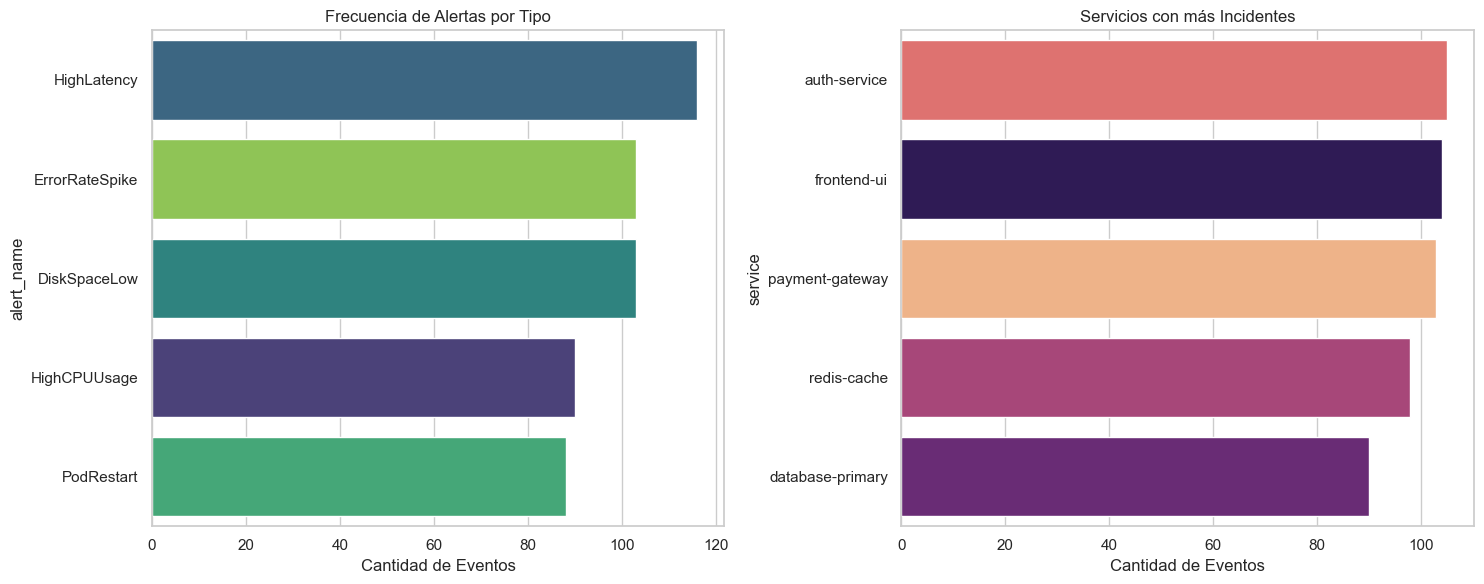

In [6]:
# Crear dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Top Alertas
sns.countplot(y='alert_name', data=df, order=df['alert_name'].value_counts().index, ax=axes[0], palette='viridis', hue='alert_name', legend=False)
axes[0].set_title('Frecuencia de Alertas por Tipo')
axes[0].set_xlabel('Cantidad de Eventos')

# Gráfico 2: Top Servicios Afectados
sns.countplot(y='service', data=df, order=df['service'].value_counts().index, ax=axes[1], palette='magma', hue='service', legend=False)
axes[1].set_title('Servicios con más Incidentes')
axes[1].set_xlabel('Cantidad de Eventos')

plt.tight_layout()
plt.show()

**Paso 4: Distribución de Duración (Boxplot)**

![Boxplot](../images/boxplot-2.png)

*Objetivo:* Detectar anomalías extremas (outliers). Un boxplot nos muestra dónde se concentra la mayoría de los datos y cuáles fueron incidentes atípicos.

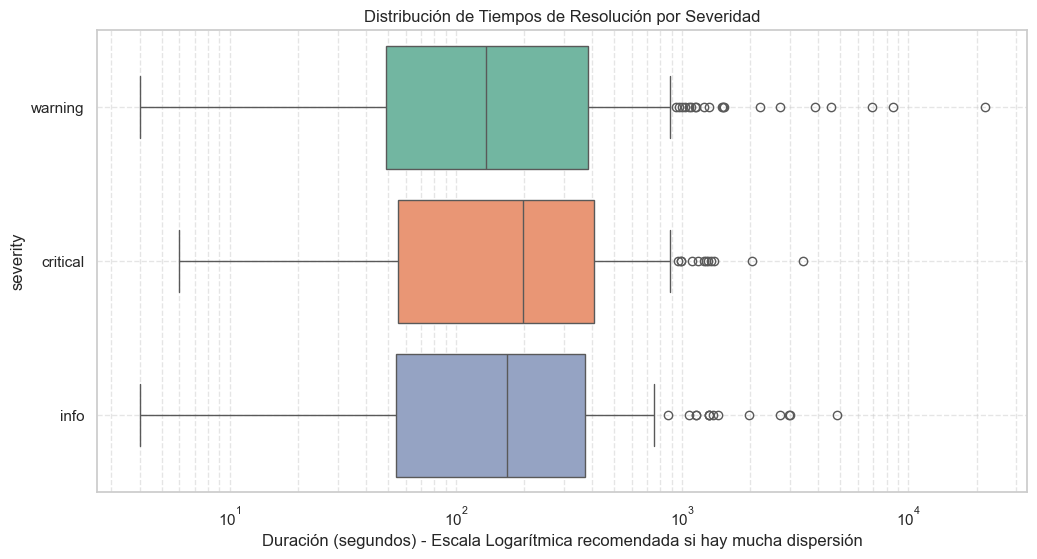

In [7]:
plt.figure(figsize=(12, 6))

# Boxplot agrupado por Severidad
sns.boxplot(x='duration_seconds', y='severity', data=df, palette='Set2', hue='severity', legend=False)

plt.title('Distribución de Tiempos de Resolución por Severidad')
plt.xlabel('Duración (segundos) - Escala Logarítmica recomendada si hay mucha dispersión')
plt.xscale('log') # Truco de experto: Usamos escala logarítmica porque los tiempos varían mucho
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

**Paso 5: Análisis de Series de Tiempo**

*Objetivo:* Ver la "salud" del sistema a lo largo del tiempo. ¿Hubo picos de alertas ayer?

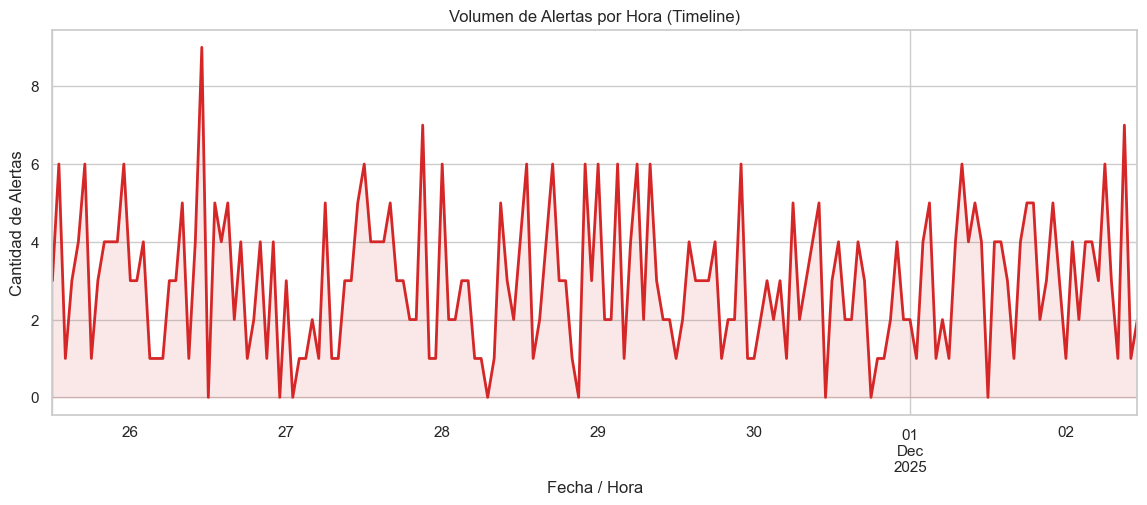

In [8]:
# Vamos a "resamplear" (agrupar) los datos por hora para ver el volumen
# Ponemos el timestamp como índice
df_time = df.set_index('timestamp')

# Contamos alertas por hora ('H')
alerts_per_hour = df_time.resample('h').size()

plt.figure(figsize=(14, 5))
alerts_per_hour.plot(kind='line', color='#d62728', lw=2)

plt.title('Volumen de Alertas por Hora (Timeline)')
plt.ylabel('Cantidad de Alertas')
plt.xlabel('Fecha / Hora')
plt.fill_between(alerts_per_hour.index, alerts_per_hour, color='#d62728', alpha=0.1) # Área sombreada
plt.show()

**La ñapa - Mapa de Calor**

Dataset cargado: 500 filas, 8 columnas.


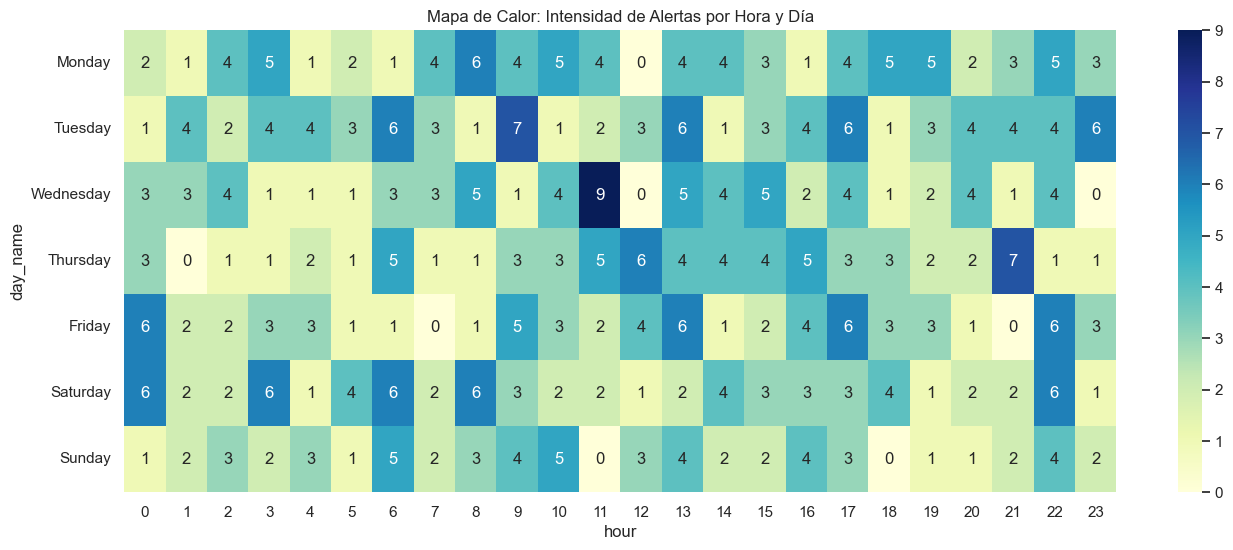

In [9]:
# Añadimos columnas derivadas útiles para análisis de tiempo
df['hour'] = df['timestamp'].dt.hour
df['day_name'] = df['timestamp'].dt.day_name()

print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas.")
df.head()

# Pivot table para mapa de calor: Día de la semana vs Hora del día
heatmap_data = df.pivot_table(index='day_name', columns='hour', values='alert_name', aggfunc='count', fill_value=0)

# Ordenar días
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Mapa de Calor: Intensidad de Alertas por Hora y Día')
plt.show()

## Conclusión:

Al finalizar este notebook, deberías hacerte las siguientes preguntas basadas en los datos:

**El Principio de Pareto:** ¿Está el 80% del ruido viniendo de solo el 20% de los tipos de alertas? (Mira el Paso 3). Si es así, ataca esas alertas primero para reducir la fatiga de alertas.

**Los Outliers:** En el Boxplot (Paso 4), ¿Ves puntos muy alejados a la derecha? Esos son los incidentes que "rompieron" el SLA. Analízalos individualmente (Post-Mortem).

**MTTR:** No uses el promedio (mean). Fíjate en la mediana (50%) para el caso típico y en el 95% para el peor caso esperado.